# Tema 19: Fundamentos de modelado estadístico

Esta es la última lección de la unidad y el objetivo es demostrar algunos fundamentos del análisis estadístico por modelos.

Comenzaremos por construir manualmente una regresión lineal bivariada, luego veremos cómo se realiza el procedimiento con `scipy` y finalmente, veremos cómo ejecutar un modelo de mínimos cuadrados ordinarios multivariado utilizando `statsmodels`.

:::{important}
Para esta libreta, deberás tener instalado `statsmodels` además de las librerías que se utilizaron en esta lección.
Si no lo haz hecho, puedes agregar la librería a tu entorno con `uv add statsmodels`. Esta librería también ya está preinstalada en `colab`.
:::

## Librerías


In [20]:
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
print('librerías cargadas')

librerías cargadas


## Datos

In [2]:
url = 'https://raw.githubusercontent.com/raphaelvallat/pingouin/refs/heads/main/src/pingouin/datasets/penguins.csv'

df = pd.read_csv(url)
df.head()


,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Biscoe,37.8,18.3,174.0,3400.0,female
1,Adelie,Biscoe,37.7,18.7,180.0,3600.0,male
2,Adelie,Biscoe,35.9,19.2,189.0,3800.0,female
3,Adelie,Biscoe,38.2,18.1,185.0,3950.0,male
4,Adelie,Biscoe,38.8,17.2,180.0,3800.0,male


## Regresión Lineal Bivariada (A mano)

En la regresión lineal, se pretende predecir el valor de la variable Y con base en la eciacoón de la recta:

$y \sim \beta_0 + \beta_1X + \epsilon$

Es importante tener en claro que $\beta_0$ es el intercepto, donde la línea cruza la ordenada, y $\beta_1$ es la pendiente de la recta. Finalmente, ya que a menos que la relación entre X y Y sea perfecta, siempre va a haber un error, que representa epsilon.

Para calcular la pendiente y el intercepto las fórmulas son:

$\text{Pendiente} =\beta_1 = \frac{\sum(x_i-\bar{x})(y_i-\bar{y})}{\sum(x_i-\bar{x})^2}$

$\text{Intercepto} = \beta_0 = \bar{y} - \beta_1\bar{x}$

Y finalmente, podemos predecir los valores de Y con base en los de X por medio de la siguiente fórmula:

$y_{pred} = \beta_0 + \beta_1 x$

A continuación pondremos estas fórmulas en una sola función, que devolverá el intercepto y la pendiente:

In [ ]:
def linreg(x: pd.Series, y: pd.Series):
  "x, y deben ser tipo pd.Series"
  x_media = x.mean() # media x
  y_media = y.mean() # media y
  numerador = sum(     # numerador de b1
      (x-x_media) * (y-y_media) 
      # restamos cada valor de x su media y cada valor de y su media también
      # obtenemos el producto
  )
  # recuerda que sum es la suma.
  # el numerador va a ser la suma de productos
  denominador = sum(   # denominador de b1
      (x-x_media)**2 # restamos la media de X a cada valor de X y los elevamos al cuadrado
  )
  # el denominador es la suma del cuadrado de las diferencias de x y su media.
  beta_1 = numerador/denominador # pendiente
  beta_0 = y_media - beta_1 * x_media # intercepto
  return beta_0, beta_1
print("Función linreg definida")

Función linreg definida


### Ejercicio
Revisa línea por línea la función y prueba en una celda de código limpia cada línea para entender qué hace. Utiliza cualquier variable de nuestros datos (cualquier columna).

### Provemos la función
Utilizaremos ahora esta función que creamos con dos variables, `bill_length_mm` y `body_mass_g`, y veremos si existe linealidad entre ellas.

In [7]:
datos_completos = df.dropna(subset=['bill_length_mm', 'body_mass_g'])
x = datos_completos['bill_length_mm']
y = datos_completos['body_mass_g']
intercepto, pendiente = linreg(x, y)
print('Intercepto', intercepto, 'pendiente', pendiente)


Intercepto 362.3067216539207 pendiente 87.41527705287552


Con estos valores y utilizando la fórmula de $y_{pred}$ calcularemos ahora los valores predichos para `body_mass_g` que es nuestra variable Y.

In [8]:
y_pred = intercepto + pendiente * x
print(y_pred)

0      3666.604194
1      3657.862667
2      3500.515168
3      3701.570305
4      3754.019471
          ...     
338    4488.307799
340    4453.341688
341    4768.036685
342    4313.477244
343    4724.329047
Name: bill_length_mm, Length: 342, dtype: float64


Fantástico, tenemos ahora un arreglo de datos con los valores predichos, visualicemos la regresión y los residuos usando `matplotlib`.

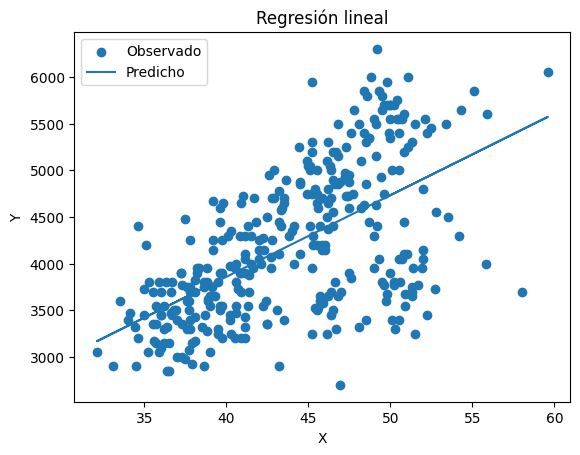

In [32]:
plt.scatter(x, y, label='Observado') 
# dispersión simple
plt.plot(x, y_pred, label='Predicho') 
# línea de la regresión
plt.xlabel('X') # formato
plt.ylabel('Y') # formato
plt.title('Regresión lineal') # formato
plt.legend() # formato
plt.show()

Muy bien, ahora, como comentamos en una lección previa, esta tarea es tan usual que muy rara vez tenenmos que hacerla a mano, `scipy` y `seaborn` ya tienen funciones para analizar estos datos. 

## Regresión lineal bivariada (real)
Utilicemos el poder de las librerías para realizar la regresión.

In [18]:
result = stats.linregress(x, y)
result

LinregressResult(slope=np.float64(87.41527705287551), intercept=np.float64(362.30672165392116), rvalue=np.float64(0.59510982443763), pvalue=np.float64(3.808282842018129e-34), stderr=np.float64(6.40198532585216), intercept_stderr=np.float64(283.3452325948302))

`scipy` confirma que nuestros cálculos estaban bien, pero también nos da el valor p y el coeficiente de correlación r. Ahora visualicemos los residuos con `seaborn`.

<Axes: xlabel='bill_length_mm', ylabel='body_mass_g'>

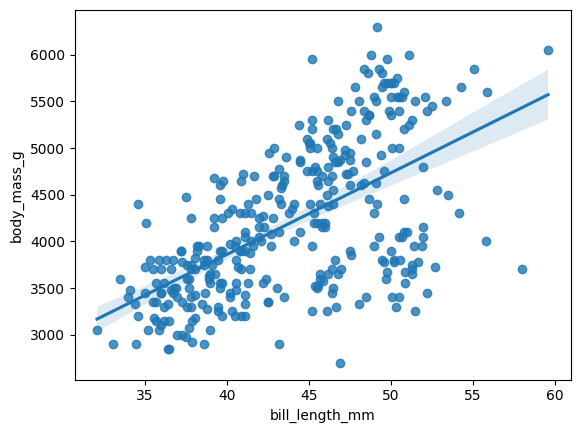

In [33]:
sns.regplot(x=x, y=y)

## Regresión multivariada
Para modelos más complejos necesitamos utilizar `statsmodels` para modelar la interacción de más variables.
Contemplemos la siguiente fórmula de regresión:

$peso \sim pico + especie$

En este caso necesitamos especificar un modelo más complejo, utilizaremos el modelo de mínimos cuadrados ordinarios.

Observa en la sección de librerías que importamos `statsmodels.api` como `sm`.

In [ ]:
datos_completos = df.dropna(subset=['bill_length_mm', 'species', 'body_mass_g'])
y = datos_completos['body_mass_g']
X = datos_completos[['bill_length_mm', 'species']]
# X es el conjunto de predictores

# Necesitamos generar variables "dummy" para cada especie
# es decir, una columna por cada especie con 0 y 1.
X = (
    pd.get_dummies( # obtiene los dummies de la variable X 
        X, 
        columns=['species'], 
        drop_first=True
    )
    .astype(float)
)
# Para poder centrar el modelo requerimos añadir una constante.
X = sm.add_constant(X)
modelo = sm.OLS(y, X) # define al modelo
resultado = modelo.fit() # ajusta los datos
print(resultado.summary())

                            OLS Regression Results                            
Dep. Variable:            body_mass_g   R-squared:                       0.783
Model:                            OLS   Adj. R-squared:                  0.781
Method:                 Least Squares   F-statistic:                     406.3
Date:                Mon, 07 Jul 2025   Prob (F-statistic):          1.03e-111
Time:                        21:58:10   Log-Likelihood:                -2510.6
No. Observations:                 342   AIC:                             5029.
Df Residuals:                     338   BIC:                             5044.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const               153.7397    268.90

:::{important}
Cuando definimos el modelo agregamos los términos `y` y `X`. 
`y` se denomina "Endog", la variable endógena, la que queremos predecir.
`X` se denomina "Exog", las variables exógenas, las predictoras.

Este concepto es clave y va a ser necesario en esta libreta más adelante.

:::

Como puedes ver el código es bastante complejo, pero no te preocupes, existe una forma más sencilla de realizar esta misma regresión.
La sintaxis de fórmula permite que especifiquemos modelos con mucha mayor facilidad y es más versátil para análisis complejos como se verá más adelante.

In [30]:
modelo = sm.OLS.from_formula(
    'body_mass_g ~ bill_length_mm + species', 
    df
)
resultado = modelo.fit()
print(resultado.summary())

                            OLS Regression Results                            
Dep. Variable:            body_mass_g   R-squared:                       0.783
Model:                            OLS   Adj. R-squared:                  0.781
Method:                 Least Squares   F-statistic:                     406.3
Date:                Mon, 07 Jul 2025   Prob (F-statistic):          1.03e-111
Time:                        22:00:05   Log-Likelihood:                -2510.6
No. Observations:                 342   AIC:                             5029.
Df Residuals:                     338   BIC:                             5044.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept              153.7397 

Los resultados son exactamente iguales pero no tenemos que quitar los NaN, ni agregar constantes, ni separar a los dummies, nada de eso, porque todo está en nuestra ecuación.

La fórmula tiene dos partes, a la izquierda de `~` está la variable objetivo, la que queremos predecir con el modelo, a la derecha está la expresión de la regresión, en un modelo sumativo, como el que se muestra en el ejemplo, separamos cada variable predictora con `+`, esto significa que cada predictor es independiente y no hay términos de interacción.

La sintaxis de fórmula se derivó de la notación matemática de la regresión y se usa en múltiples lenguaje y librerías, aunque cada uno tiene sus particularidades.

Puedes leer más de la sintaxis de fórmula, para `statsmodels` [aquí](https://www.statsmodels.org/dev/example_formulas.html#fitting-models-using-r-style-formulas) y para `R` en este [enlace](https://www.datacamp.com/tutorial/r-formula-tutorial).



### Análisis post-hoc de la regresión

Cuando analizamos el resultado de un modelo de regresión existen múltiples datos en los nos fijamos para corroborar supuestos y analizar la bondad de ajuste del modelo, exploraremos algunos de los más utilizados.

#### VIF

El `VIF` o *Variance Inflation Factor* es un análisis que nos permite identificar la colinealidad entre los predictores, en este caso `bill_length_mm` y `species`.

Para realizar este análisis lo que hacemos es extraer los predictores y aplicar la funcion VIF como se muestra a continuación.

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

X = (
    resultado # el resultado de modelo.fit()
    .model    # el modelo subyacente
    .exog     # el arreglo de datos de las predictoras
    [:, 1:]   # en el slice el primer ":" quiere decir todas las filas
              # el segundo término "1:" quiere decir todas las columnas
              # menos la primera, es decir, el intercepto.
)
nombres = (
    resultado   # el resultado de modelo.fit()
    .model      # el modelo subyacente
    .exog_names # nombre de las variables predictoras (X)
    [1:]        # todos menos el primero, que es el intercepto.
)

vif = pd.DataFrame(   # para guardar el resultado
    columns=['VIF'],  # con una columna del VIF
    index=nombres     # con el nombre de las variables
)  
for indice in range(len(nombres)): # la primera variable es 0, la segunda 1, y así suscesivamente
    nombre = nombres[indice]  
    vif.loc[nombre] = variance_inflation_factor(X, indice)
    # calculamos el vif para cada variable, pero como el VIF es para todas las predictoras
    # necesitamos pasar toda la X como argumento y el índice de la variable en el arreglo.

vif

,VIF
species[T.Chinstrap],1.704471
species[T.Gentoo],2.205853
bill_length_mm,2.910323


Como podemos ver el VIF es aceptable e indica una baja probabilidad de multicolinariedad entre los predictores.

:::{note}
En el ejemplo de arriba, observa como casi al final del código dice `vif.loc`, analicémos qué significa.
`vif` es un `dataframe`, un arreglo de datos, `loc` es un atributo que permite acceder a los valores de la tabla con base en la posición de fila y columna. `df.loc[fila, columna]`, podemos pasar valores específicos, por ejemplo, `df.loc[0, 'body_masS_g']` nos va a dar el peso del primer pingüino en el arreglo, pero las columnas son opcionales, es decir, `df.loc[0]` regresa toda la información del primer pingüino.

En el ejemplo del VIF lo que estamos es pasando la fila que queremos, es decir el nombre de la variable, porque está en el índice.
:::

#### Gráfico de residuos

Para corroborar supuestos de homocedasticidad y normalidad en residos aplicamos estos gráficos, podemos utilizar `seaborn`, aunque `statsmodels` puede generar algunos más especializados con ayuda de `matplotlib`.
 

Text(0.5, 0, 'Ajustado')

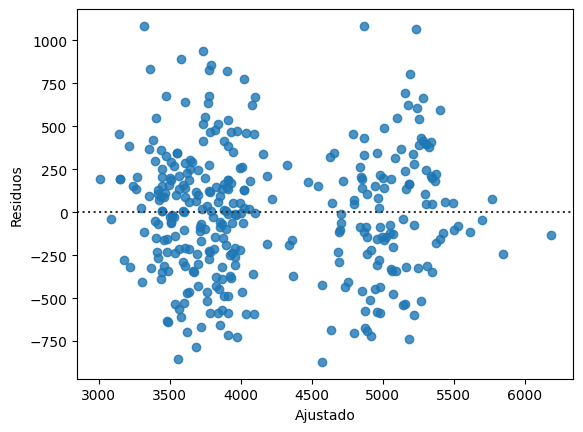

In [68]:
ajustado = resultado.fittedvalues # los valores ajustados de EXOG
residuos = resultado.resid     # el valor real de ENDOG 
                                # menos los valores predichos por el modelo
                                # es decir, los errores.
sns.residplot(x=ajustado, y=residuos)
plt.ylabel('Residuos')
plt.xlabel('Ajustado')

Podemos ver dos conglomerados con claridad, veamos usemos un diagrama de dispersión con color por especie


Text(0.5, 0, 'Ajustado')

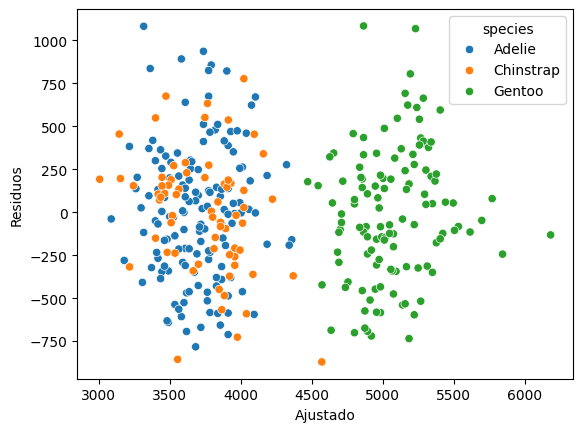

In [67]:
sns.scatterplot(x=ajustado, y=residuos, hue=df['species'])
plt.ylabel('Residuos')
plt.xlabel('Ajustado')

Efectivamente hay separación entre las especies, como habíamos visto ya previamente, en varios aspectos Adelie y Chinstrap se mueven juntos.

#### Gráficos parciales de la regresión

Siven para conocer la pendiente del modelo para cada predictor.

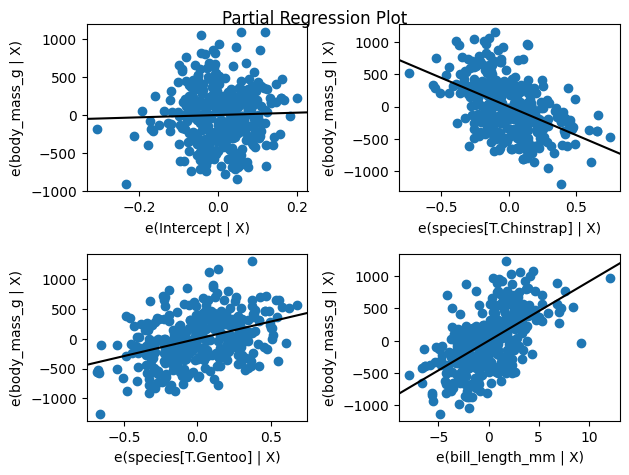

In [71]:
sm.graphics.plot_partregress_grid(resultado)
plt.show() # intenta quitar esto y ve el resultado.

En los ejes se ve la leyenda `e(variable | X)`, esto son los valores explicados por la variable en cuestión dada la constante en los demás términos.

#### Influencia de outliers

Veamos un gráfico de influencia con criterio de Cooks.

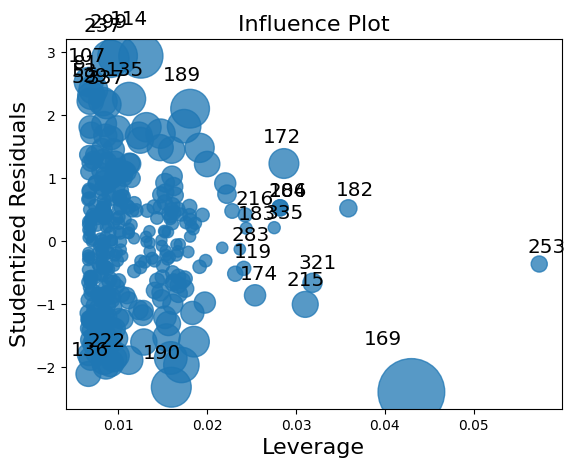

In [74]:
sm.graphics.influence_plot(resultado, criterion='cooks')
plt.show()

como podemos ver existen algunos pingüinos atíticos que ejercen una mayor influencia en el modelo, por ejemplo el 169, que podemos analizar con `df.loc`.

In [ ]:
df.loc[169] # Pingüino 169

species              Chinstrap
island                   Dream
bill_length_mm            58.0
bill_depth_mm             17.8
flipper_length_mm        181.0
body_mass_g             3700.0
sex                     female
Name: 169, dtype: object

##### Ejercicio
Intenta analizar qué de este pingüino pudiera estar generando esta influencia tan grande.

### Recursos adicionales

Revisa la documentación de `statsmodels` para conocer otras funciones relacionadas, específiametne [esta](https://www.statsmodels.org/dev/examples/notebooks/generated/regression_plots.html) página.

## Conclusión

Es posible realizar múltiples tipos de inferencia estadística desde básica hasta compleja en python, y dado que python es uno de los principales lenguajes en el mundo para el análisis de datos, muchos de los problemas que podemos encontrar ya han sido implementados y podemos simplificar nuestros flujos de trabajo, por ejemplo, con `scipy` y `statsmodels`.

Con esto concluimos la unidad 4, en la siguiente unidad veremos cómo realizar análisis específicos con más profundiad, incluidos aquellos que no vimos en esta unidad, como ANOVA, pruebas pareadas o modelos lineales generalizados.    